### Siamese GAN

image_size = 32
channels = 1


In [1]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

In [2]:
ngpu = 0
pathA = "Data/SpectrogramsA"
pathB = "Data/SpectrogramsB"
filename_gen = "SDGAN/smoothing_with_noise_gen4layers_40epoci/SDGAN-Gen.joblib"
filename_dis = "SDGAN/smoothing_with_noise_gen4layers_40epoci/SDGAN-Dis.joblib"
workers = 2
batch_size = 32

image_size = 32

# channels nr for input images
nc = 1
# size of feature maps in generator
ngf = 64
# size of feature maps in discriminator
ndf = 64
# length of latent vector
lenvec = 32

num_epochs = 40
lr = 0.0002
lrD = 0.000001
beta1 = 0.5

def find_classes(directory:str):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_index = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_index

In [3]:
class MyImageFolder(torch.utils.data.Dataset):
    def __init__(self, directory:str, transform=None):

        self.paths = list(pathlib.Path(directory).glob('*/*.jpg')) * 3

        self.transform = transform
        self.classes, self.class_to_index = find_classes(directory)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_index = self.class_to_index[class_name]

        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),  # imaginile sunt normalizate intre [0, 1]
            torchvision.transforms.Normalize(0.5, 0.5),  # imaginile sunt normalizate intre [-1, 1]
        ])


In [4]:
train_data_A = MyImageFolder(directory=pathA, transform=transform)
train_data_A, test_data_A, validation_data_A = \
    torch.utils.data.random_split(train_data_A, [len(train_data_A) - 64, 32, 32])

print(len(test_data_A))
print(len(train_data_A))
print(len(validation_data_A))

train_data_B = MyImageFolder(directory=pathB, transform=transform)

dataloader_A = torch.utils.data.DataLoader(train_data_A, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(dataloader_A))
testloader_A = torch.utils.data.DataLoader(test_data_A, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader_A = torch.utils.data.DataLoader(test_data_A, batch_size=batch_size, shuffle=True, num_workers=2)

dataloader_B = torch.utils.data.DataLoader(train_data_B, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


17220
32
17156
32
537


In [5]:
'''
Gaussian distribution (also known as normal distribution) is a bell-shaped curve, and it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.
'''
class GaussianNoise(torch.nn.Module):
    def __init__(self, std=0.1, decay=0):
        super().__init__()
        self.std = std
        self.decay = decay

    def step(self):
        self.std = max(self.std - self.decay, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [6]:
'''
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [7]:
generator = torch.nn.Sequential(
    # 1 x 32 x 32
    # downsampling
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 16 x 16

    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 8 x 8

    # upsampling
    torch.nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 16 x 16

    torch.nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh(),
    # nc x 32 x 32
)

generator.apply(weights_init)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

In [8]:
discriminator = torch.nn.Sequential(
    # nc x 32 x 32
    GaussianNoise(),
    torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf x 16 x 16

    GaussianNoise(),
    torch.nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
    torch.nn.BatchNorm2d(ndf * 2),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf*2 x 16 x 16

    GaussianNoise(),
    torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    torch.nn.BatchNorm2d(ndf * 4),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf*4 x 8 x 8

    GaussianNoise(),
    torch.nn.Conv2d(ndf * 4, nc, (3, 7), 1, 1, bias=False),
    torch.nn.Sigmoid(),
    # 1 x 8 x 4
)

discriminator.apply(weights_init)

Sequential(
  (0): GaussianNoise()
  (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): GaussianNoise()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): GaussianNoise()
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): GaussianNoise()
  (12): Conv2d(256, 1, kernel_size=(3, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (13): Sigmoid()
)

In [9]:
adversarial_loss = torch.nn.BCELoss()
contrastive_loss = torch.nn.CosineEmbeddingLoss(margin=0.2)

fixed_noise = torch.randn(batch_size, nc, image_size, image_size, device=device)
different_classes = -1
same_class = 1
real_label = 0
fake_label = 1

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999))
scheduler_gen = ReduceLROnPlateau(gen_optimizer, patience=2, factor=0.1, min_lr=0.00000001, verbose=True)
scheduler_dis = ReduceLROnPlateau(dis_optimizer, patience=1, factor=0.1, min_lr=0.0000001)

In [10]:
def normalize(x, minim, maxim):
    return (x - minim) / (maxim - minim)

def smooth_label(label, size1, size2):
    arr = torch.rand((size1, size2), dtype=torch.float, device=device)
    if label == 1:
        for i in range(arr.shape[0]):
            arr[i] = normalize(arr[i], 0.7, 1.2)
    else:
        for i in range(arr.shape[0]):
            arr[i] = normalize(arr[i], 0.0, 0.3)
    return arr

img_lists = []
gen_losses = []
dis_losses = []
iters = 0


In [11]:
for epoch in range(num_epochs):
    err_dis = 0
    err_gen = 0
    for i, (data_A, data_B) in tqdm(enumerate(zip(dataloader_A, dataloader_B))):

        A = data_A[0].to(device)
        B = data_B[0].to(device)
        # data[0] sunt imaginile si data[1] sunt labelurile
        A_size = A.size(0)  # batch size
        B_size = B.size(0)

        # Training the discriminator
        discriminator.zero_grad()
        output = discriminator(B).view(B_size, -1)
        class_ = torch.full((B_size,), same_class, dtype=torch.float, device=device)
        #label = torch.full((B_size, output.shape[1],), real_label, dtype=torch.float, device=device)
        label = smooth_label(real_label, B_size, output.shape[1])
        zero_point = torch.full((B_size, output.shape[1],), 0, dtype=torch.float, device=device)

        err_dis_real_contrs = contrastive_loss(output, zero_point, class_)
        err_dis_real_bce = adversarial_loss(output, label)
        err_dis_real = err_dis_real_bce + err_dis_real_contrs
        # counting changes in weights
        err_dis_real.backward()
        dis_x = output.mean().item()

        generated = generator(A)
        class_ = torch.full((A_size,), different_classes, dtype=torch.float, device=device)
        output = discriminator(generated.detach()).view(A_size, -1)
        #label = torch.full((A_size, output.shape[1],), fake_label, dtype=torch.float, device=device)
        label = smooth_label(fake_label, A_size, output.shape[1])
        zero_point = torch.full((A_size, output.shape[1],), 0, dtype=torch.float, device=device)

        err_dis_fake_contrs = contrastive_loss(output, zero_point, class_)
        err_dis_fake_bce = adversarial_loss(output, label)
        err_dis_fake = err_dis_fake_bce + err_dis_fake_contrs
        err_dis_fake.backward()
        dis_gen_z1 = output.mean().item()
        err_dis = err_dis_real + err_dis_fake
        # Update discriminator
        dis_optimizer.step()

        generator.zero_grad()
        class_.fill_(same_class)
        label = smooth_label(real_label, A_size, output.shape[1])
        output = discriminator(generated).view(A_size, -1)
        zero_point = torch.full((A_size,output.shape[1],), 0, dtype=torch.float, device=device)

        err_gen_contra = contrastive_loss(output, zero_point, class_)
        err_gen_bce = adversarial_loss(output, label)
        err_gen = err_gen_bce + err_gen_contra
        err_gen.backward()
        dis_gen_z2 = output.mean().item()
        gen_optimizer.step()

        if i % 100 == 0 and i != 0:
            print(f"[{epoch}/{num_epochs - 1}] [{i}/{len(dataloader_A) - 1}]\tLoss_dis: {err_dis.item():.4f}\tLoss_gen: {err_gen.item():.4f}\tD(x): {dis_x:.4f}\tD(G(x)): {dis_gen_z1:.4f} / {dis_gen_z2:.4f}")

        gen_losses.append(err_gen.item())
        dis_losses.append(err_dis.item())

        if iters % 500 == 0 or ((epoch == num_epochs - 1) and (i == len(dataloader_A) - 1)):
            with torch.no_grad():
                for fake in validationloader_A:
                    fake = fake[0]
                #fake = generator(fake).detach().cpu()
                    genererated = generator(fake)
            img_lists.append(torchvision.utils.make_grid(genererated, padding=2, normalize=True))

        iters += 1

    scheduler_gen.step(err_gen.item())
    # scheduler_dis.step(err_dis.item())

    joblib.dump(generator, filename_gen)
    joblib.dump(generator, filename_dis)

    gen_losses_arr = np.array(gen_losses, dtype=object)
    dis_losses_arr = np.array(dis_losses, dtype=object)
    img_arr = np.array(img_lists, dtype=object)
    np.save('SDGAN/smoothing_with_noise_gen4layers_40epoci/SDGAN-gen_losses.npy', gen_losses_arr)
    np.save('SDGAN/smoothing_with_noise_gen4layers_40epoci/SDGAN-dis_losses.npy', dis_losses_arr)
    np.save('SDGAN/smoothing_with_noise_gen4layers_40epoci/SDGAN-imgs.npy', img_arr)


101it [00:22,  4.64it/s]

[0/39] [100/536]	Loss_dis: 3.1666	Loss_gen: 1.8081	D(x): 0.3927	D(G(x)): 0.5008 / 0.5035


201it [00:44,  4.40it/s]

[0/39] [200/536]	Loss_dis: 3.0111	Loss_gen: 1.6820	D(x): 0.4323	D(G(x)): 0.5113 / 0.5152


301it [01:09,  4.54it/s]

[0/39] [300/536]	Loss_dis: 2.8785	Loss_gen: 1.6366	D(x): 0.4531	D(G(x)): 0.5183 / 0.5259


401it [01:32,  4.53it/s]

[0/39] [400/536]	Loss_dis: 2.7891	Loss_gen: 1.6213	D(x): 0.4879	D(G(x)): 0.5392 / 0.5274


500it [01:56,  4.27it/s]

[0/39] [500/536]	Loss_dis: 2.7470	Loss_gen: 1.3961	D(x): 0.5226	D(G(x)): 0.5651 / 0.5682


537it [02:06,  4.25it/s]
/tmp/ipykernel_31053/3600575303.py:91: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img_arr = np.array(img_lists, dtype=object)
101it [00:25,  4.34it/s]

[1/39] [100/536]	Loss_dis: 2.5028	Loss_gen: 1.3667	D(x): 0.5592	D(G(x)): 0.5688 / 0.5752


201it [00:50,  4.15it/s]

[1/39] [200/536]	Loss_dis: 2.4758	Loss_gen: 1.3333	D(x): 0.5843	D(G(x)): 0.5738 / 0.5759


301it [01:15,  3.95it/s]

[1/39] [300/536]	Loss_dis: 2.5590	Loss_gen: 1.2209	D(x): 0.5824	D(G(x)): 0.5916 / 0.5957


401it [01:40,  4.06it/s]

[1/39] [400/536]	Loss_dis: 2.4599	Loss_gen: 1.3210	D(x): 0.6030	D(G(x)): 0.6002 / 0.5904


501it [02:05,  4.09it/s]

[1/39] [500/536]	Loss_dis: 2.3828	Loss_gen: 1.3380	D(x): 0.6097	D(G(x)): 0.5944 / 0.5929


537it [02:14,  4.01it/s]
101it [00:25,  4.12it/s]

[2/39] [100/536]	Loss_dis: 2.4822	Loss_gen: 1.1470	D(x): 0.6270	D(G(x)): 0.6229 / 0.6226


201it [00:50,  4.11it/s]

[2/39] [200/536]	Loss_dis: 2.4447	Loss_gen: 1.1745	D(x): 0.6201	D(G(x)): 0.6139 / 0.6211


301it [01:14,  4.18it/s]

[2/39] [300/536]	Loss_dis: 2.4850	Loss_gen: 1.1523	D(x): 0.6277	D(G(x)): 0.6197 / 0.6221


401it [01:39,  3.94it/s]

[2/39] [400/536]	Loss_dis: 2.3991	Loss_gen: 1.1423	D(x): 0.6403	D(G(x)): 0.6322 / 0.6294


501it [02:04,  3.95it/s]

[2/39] [500/536]	Loss_dis: 2.4271	Loss_gen: 1.0812	D(x): 0.6298	D(G(x)): 0.6284 / 0.6297


537it [02:13,  4.03it/s]
101it [00:25,  3.92it/s]

[3/39] [100/536]	Loss_dis: 2.5498	Loss_gen: 1.0778	D(x): 0.6236	D(G(x)): 0.6319 / 0.6366


201it [00:50,  4.11it/s]

[3/39] [200/536]	Loss_dis: 2.5292	Loss_gen: 1.1290	D(x): 0.6325	D(G(x)): 0.6317 / 0.6244


301it [01:15,  4.11it/s]

[3/39] [300/536]	Loss_dis: 2.4652	Loss_gen: 1.1201	D(x): 0.6330	D(G(x)): 0.6279 / 0.6275


401it [01:40,  4.12it/s]

[3/39] [400/536]	Loss_dis: 2.4138	Loss_gen: 1.1224	D(x): 0.6343	D(G(x)): 0.6332 / 0.6244


501it [02:05,  4.03it/s]

[3/39] [500/536]	Loss_dis: 2.4954	Loss_gen: 1.0963	D(x): 0.6270	D(G(x)): 0.6240 / 0.6298


537it [02:13,  4.01it/s]
101it [00:25,  4.07it/s]

[4/39] [100/536]	Loss_dis: 2.4225	Loss_gen: 1.1933	D(x): 0.6335	D(G(x)): 0.6255 / 0.6216


201it [00:50,  4.09it/s]

[4/39] [200/536]	Loss_dis: 2.4306	Loss_gen: 1.1036	D(x): 0.6385	D(G(x)): 0.6216 / 0.6260


301it [01:14,  4.01it/s]

[4/39] [300/536]	Loss_dis: 2.4561	Loss_gen: 1.1713	D(x): 0.6353	D(G(x)): 0.6298 / 0.6236


401it [01:39,  3.82it/s]

[4/39] [400/536]	Loss_dis: 2.3399	Loss_gen: 1.1443	D(x): 0.6373	D(G(x)): 0.6198 / 0.6207


501it [02:04,  4.14it/s]

[4/39] [500/536]	Loss_dis: 2.3767	Loss_gen: 1.1189	D(x): 0.6345	D(G(x)): 0.6267 / 0.6247


537it [02:13,  4.02it/s]
101it [00:25,  3.96it/s]

[5/39] [100/536]	Loss_dis: 2.5334	Loss_gen: 1.0795	D(x): 0.6341	D(G(x)): 0.6410 / 0.6378


201it [00:50,  4.10it/s]

[5/39] [200/536]	Loss_dis: 2.5878	Loss_gen: 1.0428	D(x): 0.6257	D(G(x)): 0.6429 / 0.6366


301it [01:14,  4.03it/s]

[5/39] [300/536]	Loss_dis: 2.4923	Loss_gen: 1.0127	D(x): 0.6305	D(G(x)): 0.6330 / 0.6384


401it [01:40,  4.11it/s]

[5/39] [400/536]	Loss_dis: 2.4064	Loss_gen: 1.0593	D(x): 0.6294	D(G(x)): 0.6290 / 0.6272


501it [02:05,  3.97it/s]

[5/39] [500/536]	Loss_dis: 2.5366	Loss_gen: 1.1051	D(x): 0.6275	D(G(x)): 0.6373 / 0.6303


537it [02:13,  4.01it/s]
101it [00:25,  4.07it/s]

[6/39] [100/536]	Loss_dis: 2.4714	Loss_gen: 1.0790	D(x): 0.6311	D(G(x)): 0.6412 / 0.6323


201it [00:50,  3.98it/s]

[6/39] [200/536]	Loss_dis: 2.4555	Loss_gen: 1.1078	D(x): 0.6230	D(G(x)): 0.6294 / 0.6356


301it [01:16,  3.91it/s]

[6/39] [300/536]	Loss_dis: 2.3945	Loss_gen: 1.0630	D(x): 0.6320	D(G(x)): 0.6335 / 0.6339


401it [01:41,  3.96it/s]

[6/39] [400/536]	Loss_dis: 2.4491	Loss_gen: 1.0898	D(x): 0.6314	D(G(x)): 0.6373 / 0.6318


501it [02:06,  3.98it/s]

[6/39] [500/536]	Loss_dis: 2.4687	Loss_gen: 1.1124	D(x): 0.6305	D(G(x)): 0.6315 / 0.6295


537it [02:15,  3.95it/s]


Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.


101it [00:25,  4.14it/s]

[7/39] [100/536]	Loss_dis: 2.4292	Loss_gen: 1.0793	D(x): 0.6278	D(G(x)): 0.6250 / 0.6366


201it [00:49,  4.14it/s]

[7/39] [200/536]	Loss_dis: 2.4960	Loss_gen: 1.1452	D(x): 0.6294	D(G(x)): 0.6332 / 0.6305


301it [01:14,  4.10it/s]

[7/39] [300/536]	Loss_dis: 2.4102	Loss_gen: 1.0857	D(x): 0.6284	D(G(x)): 0.6316 / 0.6386


401it [01:39,  4.06it/s]

[7/39] [400/536]	Loss_dis: 2.5055	Loss_gen: 1.0550	D(x): 0.6284	D(G(x)): 0.6296 / 0.6342


501it [02:03,  4.01it/s]

[7/39] [500/536]	Loss_dis: 2.4364	Loss_gen: 1.1238	D(x): 0.6350	D(G(x)): 0.6271 / 0.6245


537it [02:12,  4.05it/s]
101it [00:25,  4.16it/s]

[8/39] [100/536]	Loss_dis: 2.4398	Loss_gen: 1.0823	D(x): 0.6311	D(G(x)): 0.6336 / 0.6306


201it [00:50,  4.16it/s]

[8/39] [200/536]	Loss_dis: 2.5237	Loss_gen: 1.0791	D(x): 0.6236	D(G(x)): 0.6359 / 0.6337


301it [01:14,  3.96it/s]

[8/39] [300/536]	Loss_dis: 2.4756	Loss_gen: 1.0875	D(x): 0.6308	D(G(x)): 0.6278 / 0.6269


401it [01:39,  4.11it/s]

[8/39] [400/536]	Loss_dis: 2.4434	Loss_gen: 1.1253	D(x): 0.6383	D(G(x)): 0.6336 / 0.6325


501it [02:04,  3.88it/s]

[8/39] [500/536]	Loss_dis: 2.4485	Loss_gen: 1.0506	D(x): 0.6331	D(G(x)): 0.6381 / 0.6338


537it [02:13,  4.02it/s]
101it [00:26,  4.05it/s]

[9/39] [100/536]	Loss_dis: 2.4573	Loss_gen: 1.1166	D(x): 0.6216	D(G(x)): 0.6332 / 0.6285


201it [00:51,  4.04it/s]

[9/39] [200/536]	Loss_dis: 2.4628	Loss_gen: 1.0517	D(x): 0.6305	D(G(x)): 0.6319 / 0.6295


301it [01:17,  3.85it/s]

[9/39] [300/536]	Loss_dis: 2.4503	Loss_gen: 1.0719	D(x): 0.6324	D(G(x)): 0.6349 / 0.6371


401it [01:42,  3.92it/s]

[9/39] [400/536]	Loss_dis: 2.4997	Loss_gen: 1.0554	D(x): 0.6271	D(G(x)): 0.6358 / 0.6352


501it [02:08,  3.99it/s]

[9/39] [500/536]	Loss_dis: 2.4176	Loss_gen: 1.0949	D(x): 0.6353	D(G(x)): 0.6283 / 0.6338


537it [02:17,  3.90it/s]


Epoch 00010: reducing learning rate of group 0 to 2.0000e-06.


101it [00:26,  4.06it/s]

[10/39] [100/536]	Loss_dis: 2.4744	Loss_gen: 1.0666	D(x): 0.6331	D(G(x)): 0.6338 / 0.6322


201it [00:51,  3.98it/s]

[10/39] [200/536]	Loss_dis: 2.3998	Loss_gen: 1.0480	D(x): 0.6368	D(G(x)): 0.6347 / 0.6415


301it [01:16,  3.96it/s]

[10/39] [300/536]	Loss_dis: 2.4034	Loss_gen: 1.0948	D(x): 0.6339	D(G(x)): 0.6372 / 0.6331


401it [01:41,  4.02it/s]

[10/39] [400/536]	Loss_dis: 2.4275	Loss_gen: 1.1540	D(x): 0.6334	D(G(x)): 0.6330 / 0.6294


501it [02:06,  4.06it/s]

[10/39] [500/536]	Loss_dis: 2.3984	Loss_gen: 1.0387	D(x): 0.6321	D(G(x)): 0.6358 / 0.6372


537it [02:15,  3.98it/s]
101it [00:26,  3.96it/s]

[11/39] [100/536]	Loss_dis: 2.4038	Loss_gen: 1.0600	D(x): 0.6404	D(G(x)): 0.6321 / 0.6345


201it [00:51,  4.03it/s]

[11/39] [200/536]	Loss_dis: 2.4877	Loss_gen: 1.1082	D(x): 0.6296	D(G(x)): 0.6393 / 0.6372


301it [01:16,  3.90it/s]

[11/39] [300/536]	Loss_dis: 2.3972	Loss_gen: 1.1073	D(x): 0.6281	D(G(x)): 0.6322 / 0.6325


401it [01:42,  3.67it/s]

[11/39] [400/536]	Loss_dis: 2.3994	Loss_gen: 1.0071	D(x): 0.6259	D(G(x)): 0.6284 / 0.6355


501it [02:10,  3.67it/s]

[11/39] [500/536]	Loss_dis: 2.4242	Loss_gen: 1.1079	D(x): 0.6264	D(G(x)): 0.6311 / 0.6329


537it [02:20,  3.83it/s]
101it [00:28,  3.71it/s]

[12/39] [100/536]	Loss_dis: 2.4552	Loss_gen: 1.1488	D(x): 0.6351	D(G(x)): 0.6313 / 0.6300


201it [00:55,  3.58it/s]

[12/39] [200/536]	Loss_dis: 2.3479	Loss_gen: 1.0974	D(x): 0.6349	D(G(x)): 0.6290 / 0.6343


301it [01:22,  4.51it/s]

[12/39] [300/536]	Loss_dis: 2.4973	Loss_gen: 1.0680	D(x): 0.6256	D(G(x)): 0.6354 / 0.6335


401it [01:46,  4.14it/s]

[12/39] [400/536]	Loss_dis: 2.4469	Loss_gen: 1.1179	D(x): 0.6301	D(G(x)): 0.6317 / 0.6326


501it [02:10,  4.40it/s]

[12/39] [500/536]	Loss_dis: 2.3949	Loss_gen: 1.0664	D(x): 0.6310	D(G(x)): 0.6331 / 0.6403


537it [02:19,  3.85it/s]


Epoch 00013: reducing learning rate of group 0 to 2.0000e-07.


101it [00:25,  4.40it/s]

[13/39] [100/536]	Loss_dis: 2.4805	Loss_gen: 1.0930	D(x): 0.6296	D(G(x)): 0.6339 / 0.6289


201it [00:50,  4.46it/s]

[13/39] [200/536]	Loss_dis: 2.4670	Loss_gen: 1.0729	D(x): 0.6316	D(G(x)): 0.6354 / 0.6297


301it [01:15,  4.52it/s]

[13/39] [300/536]	Loss_dis: 2.4459	Loss_gen: 1.0432	D(x): 0.6300	D(G(x)): 0.6334 / 0.6374


401it [01:40,  3.78it/s]

[13/39] [400/536]	Loss_dis: 2.4544	Loss_gen: 1.0409	D(x): 0.6332	D(G(x)): 0.6322 / 0.6347


501it [02:07,  3.82it/s]

[13/39] [500/536]	Loss_dis: 2.4025	Loss_gen: 1.0778	D(x): 0.6325	D(G(x)): 0.6305 / 0.6337


537it [02:16,  3.94it/s]
101it [00:26,  3.70it/s]

[14/39] [100/536]	Loss_dis: 2.4050	Loss_gen: 1.0196	D(x): 0.6288	D(G(x)): 0.6290 / 0.6388


201it [00:51,  4.69it/s]

[14/39] [200/536]	Loss_dis: 2.3782	Loss_gen: 1.0794	D(x): 0.6329	D(G(x)): 0.6275 / 0.6316


301it [01:17,  4.39it/s]

[14/39] [300/536]	Loss_dis: 2.4944	Loss_gen: 1.0547	D(x): 0.6233	D(G(x)): 0.6398 / 0.6304


401it [01:41,  4.30it/s]

[14/39] [400/536]	Loss_dis: 2.4300	Loss_gen: 1.0858	D(x): 0.6362	D(G(x)): 0.6291 / 0.6357


501it [02:05,  4.48it/s]

[14/39] [500/536]	Loss_dis: 2.4803	Loss_gen: 1.1023	D(x): 0.6354	D(G(x)): 0.6398 / 0.6312


537it [02:13,  4.01it/s]
101it [00:24,  4.38it/s]

[15/39] [100/536]	Loss_dis: 2.4599	Loss_gen: 1.1303	D(x): 0.6281	D(G(x)): 0.6386 / 0.6284


201it [00:50,  3.00it/s]

[15/39] [200/536]	Loss_dis: 2.4683	Loss_gen: 1.0854	D(x): 0.6291	D(G(x)): 0.6317 / 0.6336


301it [01:15,  3.16it/s]

[15/39] [300/536]	Loss_dis: 2.3476	Loss_gen: 1.0562	D(x): 0.6334	D(G(x)): 0.6297 / 0.6328


401it [01:40,  4.43it/s]

[15/39] [400/536]	Loss_dis: 2.3562	Loss_gen: 1.0967	D(x): 0.6344	D(G(x)): 0.6284 / 0.6313


501it [02:05,  4.46it/s]

[15/39] [500/536]	Loss_dis: 2.3692	Loss_gen: 1.0718	D(x): 0.6337	D(G(x)): 0.6340 / 0.6238


537it [02:13,  4.03it/s]


Epoch 00016: reducing learning rate of group 0 to 2.0000e-08.


101it [00:24,  4.40it/s]

[16/39] [100/536]	Loss_dis: 2.3784	Loss_gen: 1.0438	D(x): 0.6298	D(G(x)): 0.6290 / 0.6316


201it [00:49,  4.59it/s]

[16/39] [200/536]	Loss_dis: 2.4121	Loss_gen: 1.0741	D(x): 0.6302	D(G(x)): 0.6348 / 0.6323


301it [01:15,  3.75it/s]

[16/39] [300/536]	Loss_dis: 2.4310	Loss_gen: 1.1072	D(x): 0.6340	D(G(x)): 0.6377 / 0.6326


401it [01:39,  3.64it/s]

[16/39] [400/536]	Loss_dis: 2.4004	Loss_gen: 1.0824	D(x): 0.6365	D(G(x)): 0.6335 / 0.6357


501it [02:03,  3.66it/s]

[16/39] [500/536]	Loss_dis: 2.3454	Loss_gen: 1.1349	D(x): 0.6344	D(G(x)): 0.6273 / 0.6316


537it [02:13,  4.03it/s]
101it [00:23,  4.46it/s]

[17/39] [100/536]	Loss_dis: 2.3842	Loss_gen: 1.1203	D(x): 0.6378	D(G(x)): 0.6306 / 0.6301


201it [00:49,  3.72it/s]

[17/39] [200/536]	Loss_dis: 2.4170	Loss_gen: 1.1197	D(x): 0.6381	D(G(x)): 0.6305 / 0.6276


301it [01:12,  3.62it/s]

[17/39] [300/536]	Loss_dis: 2.4115	Loss_gen: 1.0944	D(x): 0.6319	D(G(x)): 0.6289 / 0.6294


401it [01:37,  3.42it/s]

[17/39] [400/536]	Loss_dis: 2.3535	Loss_gen: 1.0466	D(x): 0.6350	D(G(x)): 0.6325 / 0.6302


501it [02:04,  4.36it/s]

[17/39] [500/536]	Loss_dis: 2.3897	Loss_gen: 1.0936	D(x): 0.6304	D(G(x)): 0.6326 / 0.6311


537it [02:12,  4.05it/s]
101it [00:27,  4.41it/s]

[18/39] [100/536]	Loss_dis: 2.3902	Loss_gen: 1.1150	D(x): 0.6360	D(G(x)): 0.6337 / 0.6324


201it [00:52,  4.37it/s]

[18/39] [200/536]	Loss_dis: 2.4125	Loss_gen: 1.0849	D(x): 0.6349	D(G(x)): 0.6298 / 0.6329


301it [01:18,  4.36it/s]

[18/39] [300/536]	Loss_dis: 2.4089	Loss_gen: 1.1247	D(x): 0.6318	D(G(x)): 0.6300 / 0.6307


401it [01:42,  4.22it/s]

[18/39] [400/536]	Loss_dis: 2.4417	Loss_gen: 1.1119	D(x): 0.6253	D(G(x)): 0.6307 / 0.6313


501it [02:07,  4.24it/s]

[18/39] [500/536]	Loss_dis: 2.2837	Loss_gen: 1.1110	D(x): 0.6352	D(G(x)): 0.6207 / 0.6250


537it [02:18,  3.88it/s]


Epoch 00019: reducing learning rate of group 0 to 1.0000e-08.


101it [00:26,  4.24it/s]

[19/39] [100/536]	Loss_dis: 2.3634	Loss_gen: 1.1118	D(x): 0.6300	D(G(x)): 0.6231 / 0.6307


201it [00:50,  4.05it/s]

[19/39] [200/536]	Loss_dis: 2.4888	Loss_gen: 1.0561	D(x): 0.6242	D(G(x)): 0.6292 / 0.6293


301it [01:16,  4.15it/s]

[19/39] [300/536]	Loss_dis: 2.4434	Loss_gen: 1.0432	D(x): 0.6315	D(G(x)): 0.6291 / 0.6342


401it [01:41,  4.33it/s]

[19/39] [400/536]	Loss_dis: 2.4490	Loss_gen: 1.1145	D(x): 0.6293	D(G(x)): 0.6293 / 0.6268


501it [02:05,  4.40it/s]

[19/39] [500/536]	Loss_dis: 2.4279	Loss_gen: 1.0644	D(x): 0.6295	D(G(x)): 0.6297 / 0.6358


537it [02:14,  4.00it/s]
101it [00:24,  4.16it/s]

[20/39] [100/536]	Loss_dis: 2.3531	Loss_gen: 1.1117	D(x): 0.6339	D(G(x)): 0.6231 / 0.6272


201it [00:49,  4.23it/s]

[20/39] [200/536]	Loss_dis: 2.3979	Loss_gen: 1.0692	D(x): 0.6361	D(G(x)): 0.6272 / 0.6314


301it [01:13,  3.45it/s]

[20/39] [300/536]	Loss_dis: 2.3865	Loss_gen: 1.1043	D(x): 0.6321	D(G(x)): 0.6360 / 0.6273


401it [01:38,  3.86it/s]

[20/39] [400/536]	Loss_dis: 2.4137	Loss_gen: 1.0909	D(x): 0.6340	D(G(x)): 0.6348 / 0.6288


501it [02:01,  4.22it/s]

[20/39] [500/536]	Loss_dis: 2.3586	Loss_gen: 1.0676	D(x): 0.6327	D(G(x)): 0.6291 / 0.6338


537it [02:09,  4.14it/s]
101it [00:25,  3.64it/s]

[21/39] [100/536]	Loss_dis: 2.3973	Loss_gen: 1.0768	D(x): 0.6307	D(G(x)): 0.6317 / 0.6294


201it [00:50,  4.15it/s]

[21/39] [200/536]	Loss_dis: 2.4145	Loss_gen: 1.0950	D(x): 0.6336	D(G(x)): 0.6336 / 0.6288


301it [01:17,  3.65it/s]

[21/39] [300/536]	Loss_dis: 2.3643	Loss_gen: 1.0711	D(x): 0.6380	D(G(x)): 0.6287 / 0.6326


401it [01:40,  4.35it/s]

[21/39] [400/536]	Loss_dis: 2.3640	Loss_gen: 1.0954	D(x): 0.6373	D(G(x)): 0.6329 / 0.6355


501it [02:04,  4.26it/s]

[21/39] [500/536]	Loss_dis: 2.4290	Loss_gen: 1.1400	D(x): 0.6299	D(G(x)): 0.6314 / 0.6289


537it [02:12,  4.04it/s]
101it [00:25,  4.33it/s]

[22/39] [100/536]	Loss_dis: 2.3717	Loss_gen: 1.1007	D(x): 0.6331	D(G(x)): 0.6224 / 0.6339


201it [00:52,  4.31it/s]

[22/39] [200/536]	Loss_dis: 2.3889	Loss_gen: 1.1116	D(x): 0.6291	D(G(x)): 0.6334 / 0.6278


301it [01:17,  3.75it/s]

[22/39] [300/536]	Loss_dis: 2.3864	Loss_gen: 1.0678	D(x): 0.6338	D(G(x)): 0.6304 / 0.6304


401it [01:42,  4.52it/s]

[22/39] [400/536]	Loss_dis: 2.4083	Loss_gen: 1.1277	D(x): 0.6324	D(G(x)): 0.6269 / 0.6290


501it [02:05,  4.45it/s]

[22/39] [500/536]	Loss_dis: 2.4584	Loss_gen: 1.0984	D(x): 0.6273	D(G(x)): 0.6297 / 0.6272


537it [02:14,  3.98it/s]
101it [00:26,  4.44it/s]

[23/39] [100/536]	Loss_dis: 2.4166	Loss_gen: 1.1076	D(x): 0.6324	D(G(x)): 0.6348 / 0.6322


201it [00:52,  3.64it/s]

[23/39] [200/536]	Loss_dis: 2.3461	Loss_gen: 1.0957	D(x): 0.6303	D(G(x)): 0.6292 / 0.6282


301it [01:19,  4.35it/s]

[23/39] [300/536]	Loss_dis: 2.4108	Loss_gen: 1.0665	D(x): 0.6309	D(G(x)): 0.6323 / 0.6330


401it [01:43,  4.44it/s]

[23/39] [400/536]	Loss_dis: 2.3721	Loss_gen: 1.0994	D(x): 0.6349	D(G(x)): 0.6270 / 0.6278


501it [02:07,  3.69it/s]

[23/39] [500/536]	Loss_dis: 2.3478	Loss_gen: 1.0875	D(x): 0.6327	D(G(x)): 0.6320 / 0.6363


537it [02:16,  3.93it/s]
101it [00:25,  4.05it/s]

[24/39] [100/536]	Loss_dis: 2.3486	Loss_gen: 1.0772	D(x): 0.6359	D(G(x)): 0.6247 / 0.6368


201it [00:50,  3.72it/s]

[24/39] [200/536]	Loss_dis: 2.4289	Loss_gen: 1.1333	D(x): 0.6301	D(G(x)): 0.6273 / 0.6272


301it [01:13,  4.51it/s]

[24/39] [300/536]	Loss_dis: 2.3574	Loss_gen: 1.1222	D(x): 0.6392	D(G(x)): 0.6257 / 0.6304


401it [01:36,  4.28it/s]

[24/39] [400/536]	Loss_dis: 2.3539	Loss_gen: 1.1475	D(x): 0.6405	D(G(x)): 0.6301 / 0.6281


501it [02:00,  4.44it/s]

[24/39] [500/536]	Loss_dis: 2.4176	Loss_gen: 1.0604	D(x): 0.6399	D(G(x)): 0.6328 / 0.6376


537it [02:09,  4.14it/s]
101it [00:26,  4.39it/s]

[25/39] [100/536]	Loss_dis: 2.3177	Loss_gen: 1.1153	D(x): 0.6378	D(G(x)): 0.6254 / 0.6286


201it [00:50,  4.36it/s]

[25/39] [200/536]	Loss_dis: 2.3490	Loss_gen: 1.0441	D(x): 0.6369	D(G(x)): 0.6314 / 0.6328


301it [01:15,  4.37it/s]

[25/39] [300/536]	Loss_dis: 2.4685	Loss_gen: 1.0900	D(x): 0.6285	D(G(x)): 0.6302 / 0.6267


401it [01:39,  4.25it/s]

[25/39] [400/536]	Loss_dis: 2.3022	Loss_gen: 1.0985	D(x): 0.6381	D(G(x)): 0.6264 / 0.6291


501it [02:03,  4.08it/s]

[25/39] [500/536]	Loss_dis: 2.3814	Loss_gen: 1.0925	D(x): 0.6292	D(G(x)): 0.6285 / 0.6292


537it [02:11,  4.07it/s]
101it [00:25,  4.39it/s]

[26/39] [100/536]	Loss_dis: 2.4072	Loss_gen: 1.1231	D(x): 0.6344	D(G(x)): 0.6264 / 0.6237


201it [00:50,  4.33it/s]

[26/39] [200/536]	Loss_dis: 2.3234	Loss_gen: 1.1298	D(x): 0.6287	D(G(x)): 0.6219 / 0.6290


301it [01:16,  4.22it/s]

[26/39] [300/536]	Loss_dis: 2.3918	Loss_gen: 1.0749	D(x): 0.6415	D(G(x)): 0.6344 / 0.6325


401it [01:41,  3.72it/s]

[26/39] [400/536]	Loss_dis: 2.4156	Loss_gen: 1.0852	D(x): 0.6317	D(G(x)): 0.6294 / 0.6297


501it [02:05,  4.50it/s]

[26/39] [500/536]	Loss_dis: 2.4114	Loss_gen: 1.1016	D(x): 0.6266	D(G(x)): 0.6245 / 0.6324


537it [02:13,  4.01it/s]
101it [00:24,  3.59it/s]

[27/39] [100/536]	Loss_dis: 2.3831	Loss_gen: 1.1285	D(x): 0.6234	D(G(x)): 0.6261 / 0.6270


201it [00:49,  4.54it/s]

[27/39] [200/536]	Loss_dis: 2.2957	Loss_gen: 1.0800	D(x): 0.6440	D(G(x)): 0.6326 / 0.6267


301it [01:13,  4.35it/s]

[27/39] [300/536]	Loss_dis: 2.3078	Loss_gen: 1.0783	D(x): 0.6446	D(G(x)): 0.6318 / 0.6318


401it [01:38,  3.74it/s]

[27/39] [400/536]	Loss_dis: 2.3134	Loss_gen: 1.0937	D(x): 0.6346	D(G(x)): 0.6278 / 0.6271


501it [02:02,  3.67it/s]

[27/39] [500/536]	Loss_dis: 2.3357	Loss_gen: 1.1454	D(x): 0.6337	D(G(x)): 0.6236 / 0.6261


537it [02:12,  4.05it/s]
101it [00:28,  3.64it/s]

[28/39] [100/536]	Loss_dis: 2.3497	Loss_gen: 1.1530	D(x): 0.6354	D(G(x)): 0.6259 / 0.6275


201it [00:51,  3.97it/s]

[28/39] [200/536]	Loss_dis: 2.3974	Loss_gen: 1.0893	D(x): 0.6311	D(G(x)): 0.6314 / 0.6274


301it [01:16,  3.48it/s]

[28/39] [300/536]	Loss_dis: 2.3861	Loss_gen: 1.0778	D(x): 0.6381	D(G(x)): 0.6260 / 0.6364


401it [01:40,  4.39it/s]

[28/39] [400/536]	Loss_dis: 2.3549	Loss_gen: 1.1170	D(x): 0.6351	D(G(x)): 0.6240 / 0.6224


501it [02:08,  3.74it/s]

[28/39] [500/536]	Loss_dis: 2.3948	Loss_gen: 1.1102	D(x): 0.6332	D(G(x)): 0.6244 / 0.6230


537it [02:16,  3.95it/s]
101it [00:26,  4.27it/s]

[29/39] [100/536]	Loss_dis: 2.2743	Loss_gen: 1.1857	D(x): 0.6379	D(G(x)): 0.6186 / 0.6175


201it [00:50,  4.19it/s]

[29/39] [200/536]	Loss_dis: 2.3706	Loss_gen: 1.1397	D(x): 0.6347	D(G(x)): 0.6244 / 0.6241


301it [01:14,  4.36it/s]

[29/39] [300/536]	Loss_dis: 2.3120	Loss_gen: 1.1778	D(x): 0.6408	D(G(x)): 0.6251 / 0.6183


401it [01:40,  4.48it/s]

[29/39] [400/536]	Loss_dis: 2.4392	Loss_gen: 1.1211	D(x): 0.6297	D(G(x)): 0.6309 / 0.6258


501it [02:04,  4.32it/s]

[29/39] [500/536]	Loss_dis: 2.3764	Loss_gen: 1.1198	D(x): 0.6237	D(G(x)): 0.6278 / 0.6257


537it [02:12,  4.05it/s]
101it [00:25,  4.36it/s]

[30/39] [100/536]	Loss_dis: 2.2896	Loss_gen: 1.1669	D(x): 0.6373	D(G(x)): 0.6203 / 0.6205


201it [00:51,  4.35it/s]

[30/39] [200/536]	Loss_dis: 2.3728	Loss_gen: 1.1842	D(x): 0.6256	D(G(x)): 0.6221 / 0.6244


301it [01:17,  3.69it/s]

[30/39] [300/536]	Loss_dis: 2.3034	Loss_gen: 1.1902	D(x): 0.6312	D(G(x)): 0.6229 / 0.6193


401it [01:41,  3.68it/s]

[30/39] [400/536]	Loss_dis: 2.3010	Loss_gen: 1.1929	D(x): 0.6398	D(G(x)): 0.6145 / 0.6184


501it [02:06,  3.55it/s]

[30/39] [500/536]	Loss_dis: 2.2961	Loss_gen: 1.1423	D(x): 0.6407	D(G(x)): 0.6195 / 0.6251


537it [02:16,  3.94it/s]
101it [00:25,  3.58it/s]

[31/39] [100/536]	Loss_dis: 2.2971	Loss_gen: 1.1220	D(x): 0.6358	D(G(x)): 0.6253 / 0.6270


201it [00:49,  4.38it/s]

[31/39] [200/536]	Loss_dis: 2.2728	Loss_gen: 1.1138	D(x): 0.6410	D(G(x)): 0.6221 / 0.6242


301it [01:12,  4.27it/s]

[31/39] [300/536]	Loss_dis: 2.3198	Loss_gen: 1.0986	D(x): 0.6372	D(G(x)): 0.6277 / 0.6224


401it [01:36,  4.36it/s]

[31/39] [400/536]	Loss_dis: 2.3043	Loss_gen: 1.1370	D(x): 0.6336	D(G(x)): 0.6263 / 0.6169


501it [02:01,  3.67it/s]

[31/39] [500/536]	Loss_dis: 2.3215	Loss_gen: 1.1691	D(x): 0.6382	D(G(x)): 0.6210 / 0.6208


537it [02:11,  4.09it/s]
101it [00:25,  4.30it/s]

[32/39] [100/536]	Loss_dis: 2.2681	Loss_gen: 1.1413	D(x): 0.6432	D(G(x)): 0.6189 / 0.6247


201it [00:50,  4.25it/s]

[32/39] [200/536]	Loss_dis: 2.3328	Loss_gen: 1.0916	D(x): 0.6327	D(G(x)): 0.6234 / 0.6205


301it [01:15,  4.39it/s]

[32/39] [300/536]	Loss_dis: 2.3068	Loss_gen: 1.1726	D(x): 0.6300	D(G(x)): 0.6131 / 0.6191


401it [01:38,  4.31it/s]

[32/39] [400/536]	Loss_dis: 2.3041	Loss_gen: 1.1937	D(x): 0.6385	D(G(x)): 0.6218 / 0.6216


501it [02:03,  3.99it/s]

[32/39] [500/536]	Loss_dis: 2.3837	Loss_gen: 1.2060	D(x): 0.6349	D(G(x)): 0.6250 / 0.6180


537it [02:11,  4.07it/s]
101it [00:25,  4.06it/s]

[33/39] [100/536]	Loss_dis: 2.2742	Loss_gen: 1.1194	D(x): 0.6346	D(G(x)): 0.6139 / 0.6163


201it [00:50,  4.18it/s]

[33/39] [200/536]	Loss_dis: 2.3276	Loss_gen: 1.1537	D(x): 0.6440	D(G(x)): 0.6202 / 0.6188


301it [01:15,  4.23it/s]

[33/39] [300/536]	Loss_dis: 2.2890	Loss_gen: 1.1711	D(x): 0.6351	D(G(x)): 0.6172 / 0.6209


401it [01:41,  4.18it/s]

[33/39] [400/536]	Loss_dis: 2.2601	Loss_gen: 1.1620	D(x): 0.6466	D(G(x)): 0.6202 / 0.6213


501it [02:06,  4.28it/s]

[33/39] [500/536]	Loss_dis: 2.2854	Loss_gen: 1.1722	D(x): 0.6410	D(G(x)): 0.6192 / 0.6187


537it [02:16,  3.94it/s]
101it [00:25,  4.45it/s]

[34/39] [100/536]	Loss_dis: 2.3103	Loss_gen: 1.1703	D(x): 0.6322	D(G(x)): 0.6163 / 0.6186


201it [00:50,  4.30it/s]

[34/39] [200/536]	Loss_dis: 2.3179	Loss_gen: 1.1488	D(x): 0.6338	D(G(x)): 0.6145 / 0.6207


301it [01:16,  4.35it/s]

[34/39] [300/536]	Loss_dis: 2.3395	Loss_gen: 1.2032	D(x): 0.6236	D(G(x)): 0.6176 / 0.6117


401it [01:40,  4.19it/s]

[34/39] [400/536]	Loss_dis: 2.3936	Loss_gen: 1.1863	D(x): 0.6292	D(G(x)): 0.6194 / 0.6118


501it [02:08,  3.70it/s]

[34/39] [500/536]	Loss_dis: 2.3248	Loss_gen: 1.1956	D(x): 0.6320	D(G(x)): 0.6135 / 0.6101


537it [02:17,  3.90it/s]
101it [00:23,  4.33it/s]

[35/39] [100/536]	Loss_dis: 2.3103	Loss_gen: 1.1710	D(x): 0.6289	D(G(x)): 0.6123 / 0.6139


201it [00:49,  4.49it/s]

[35/39] [200/536]	Loss_dis: 2.1974	Loss_gen: 1.1643	D(x): 0.6472	D(G(x)): 0.6134 / 0.6166


301it [01:14,  4.21it/s]

[35/39] [300/536]	Loss_dis: 2.3138	Loss_gen: 1.1913	D(x): 0.6282	D(G(x)): 0.6111 / 0.6146


401it [01:38,  4.46it/s]

[35/39] [400/536]	Loss_dis: 2.2076	Loss_gen: 1.1926	D(x): 0.6376	D(G(x)): 0.6084 / 0.6099


501it [02:03,  4.26it/s]

[35/39] [500/536]	Loss_dis: 2.1687	Loss_gen: 1.1614	D(x): 0.6485	D(G(x)): 0.6117 / 0.6190


537it [02:11,  4.08it/s]
101it [00:24,  4.46it/s]

[36/39] [100/536]	Loss_dis: 2.1356	Loss_gen: 1.1949	D(x): 0.6494	D(G(x)): 0.6081 / 0.6055


201it [00:50,  3.59it/s]

[36/39] [200/536]	Loss_dis: 2.2903	Loss_gen: 1.1830	D(x): 0.6369	D(G(x)): 0.6109 / 0.6145


301it [01:15,  3.61it/s]

[36/39] [300/536]	Loss_dis: 2.3377	Loss_gen: 1.2227	D(x): 0.6177	D(G(x)): 0.6037 / 0.6055


401it [01:39,  3.57it/s]

[36/39] [400/536]	Loss_dis: 2.0913	Loss_gen: 1.2289	D(x): 0.6535	D(G(x)): 0.6091 / 0.6046


501it [02:04,  3.63it/s]

[36/39] [500/536]	Loss_dis: 2.2634	Loss_gen: 1.1808	D(x): 0.6336	D(G(x)): 0.6023 / 0.6111


537it [02:14,  3.99it/s]
101it [00:25,  3.61it/s]

[37/39] [100/536]	Loss_dis: 2.0946	Loss_gen: 1.2589	D(x): 0.6507	D(G(x)): 0.6056 / 0.6038


201it [00:53,  3.45it/s]

[37/39] [200/536]	Loss_dis: 2.0261	Loss_gen: 1.2547	D(x): 0.6768	D(G(x)): 0.6038 / 0.6028


301it [01:18,  3.45it/s]

[37/39] [300/536]	Loss_dis: 2.3398	Loss_gen: 1.2489	D(x): 0.6127	D(G(x)): 0.6062 / 0.6040


401it [01:44,  3.48it/s]

[37/39] [400/536]	Loss_dis: 2.2735	Loss_gen: 1.2306	D(x): 0.6165	D(G(x)): 0.6051 / 0.6025


501it [02:10,  3.19it/s]

[37/39] [500/536]	Loss_dis: 2.2205	Loss_gen: 1.1965	D(x): 0.6386	D(G(x)): 0.6023 / 0.6044


537it [02:20,  3.81it/s]
101it [00:26,  4.11it/s]

[38/39] [100/536]	Loss_dis: 2.1919	Loss_gen: 1.2444	D(x): 0.6348	D(G(x)): 0.5941 / 0.5975


201it [00:52,  3.67it/s]

[38/39] [200/536]	Loss_dis: 2.1992	Loss_gen: 1.1987	D(x): 0.6438	D(G(x)): 0.6082 / 0.6105


301it [01:18,  4.51it/s]

[38/39] [300/536]	Loss_dis: 2.2577	Loss_gen: 1.1848	D(x): 0.6274	D(G(x)): 0.6029 / 0.6098


401it [01:44,  3.79it/s]

[38/39] [400/536]	Loss_dis: 2.1052	Loss_gen: 1.2371	D(x): 0.6641	D(G(x)): 0.6041 / 0.6031


501it [02:10,  4.00it/s]

[38/39] [500/536]	Loss_dis: 2.3320	Loss_gen: 1.1588	D(x): 0.6073	D(G(x)): 0.5994 / 0.6093


537it [02:21,  3.81it/s]
101it [00:28,  4.33it/s]

[39/39] [100/536]	Loss_dis: 2.1944	Loss_gen: 1.2584	D(x): 0.6359	D(G(x)): 0.6031 / 0.5919


201it [00:55,  4.44it/s]

[39/39] [200/536]	Loss_dis: 2.2593	Loss_gen: 1.2739	D(x): 0.6365	D(G(x)): 0.6059 / 0.6015


301it [01:22,  3.94it/s]

[39/39] [300/536]	Loss_dis: 2.2792	Loss_gen: 1.2697	D(x): 0.6159	D(G(x)): 0.5904 / 0.5912


401it [01:46,  4.16it/s]

[39/39] [400/536]	Loss_dis: 1.8271	Loss_gen: 1.2598	D(x): 0.6984	D(G(x)): 0.5927 / 0.5964


501it [02:12,  4.02it/s]

[39/39] [500/536]	Loss_dis: 2.2502	Loss_gen: 1.2599	D(x): 0.6268	D(G(x)): 0.5942 / 0.5928


537it [02:21,  3.79it/s]


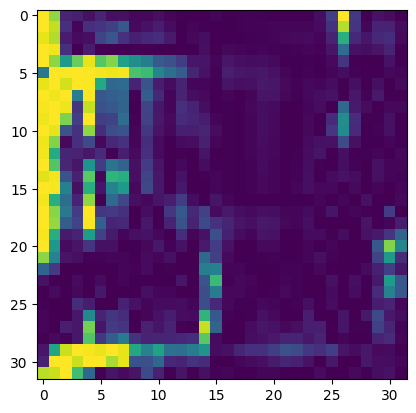

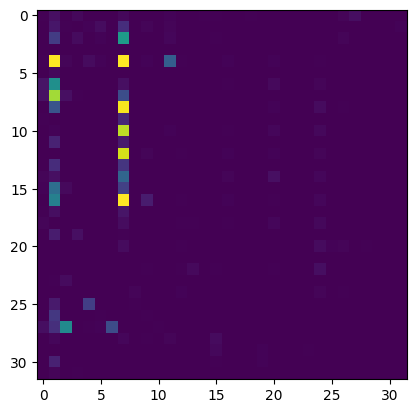

In [12]:
test_spec = Image.open("Data/SpectrogramsA/pop/pop_spec28.jpg")
make_tensor = torchvision.transforms.ToTensor()
test_spec = transform(test_spec)
test_spec = torch.transpose(test_spec, 0, 2)

fig, axs = plt.subplots(1)
axs.imshow(test_spec)
plt.show()


test_spec = torch.transpose(test_spec, 0, 2)
test_spec = torch.unsqueeze(test_spec, 0)
# test_spec = torch.transpose(test_spec, 0, 1)

test_spec = generator(test_spec)

test_spec = torch.squeeze(test_spec, 0)
test_spec = torch.transpose(test_spec, 0, 2)

fig, axs = plt.subplots(1)
axs.imshow(test_spec.detach())
plt.show()



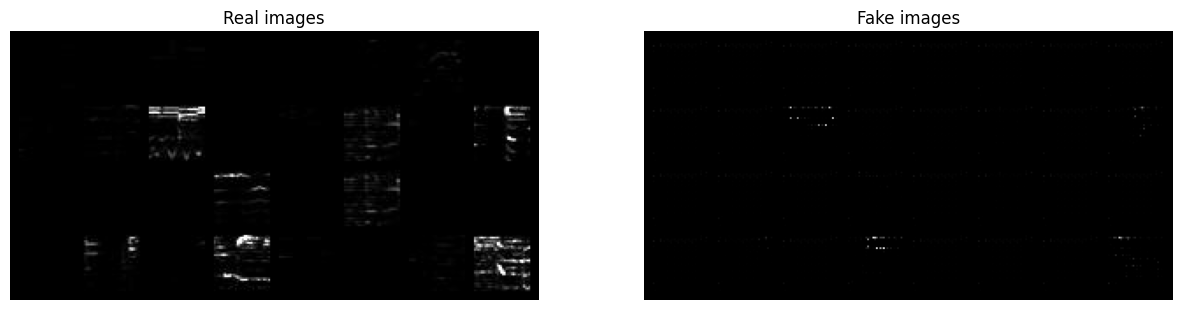

In [27]:
# real_batch = next(iter(dataloader))
real_batch = next(iter(dataloader_B))
p = real_batch[0]
res = generator(p)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(torchvision.utils.make_grid(res.to(device), padding=5, normalize=True).cpu(),(1,2,0)))



# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_lists[0],(1,2,0)))
# plt.show()